I am going to create a linear algebra model for predicting total infections. The equation will take the form of: y = a*x1 + b*x2 + c*x1*x2 + d, where y is the log10 of total infections, x1 is the log10 of transportation usage, x2 is the log10 of population density, all by county. I predict the error of this linear model will be fairly high, and most of the effect will come from the intercept. I predict this because the data vizualization seems very noisy when plotted log log.

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import statsmodels.api as sm
import math

data = pd.DataFrame(pd.read_csv(r"C:\Users\mdsnb\OneDrive\Documents\GitHub\ChE_2410_Math\Project 1\datano0transusage.csv"))

#old source file - didn't filter out 0 access to transportation
#data = pd.DataFrame(pd.read_csv(r"C:\Users\mdsnb\OneDrive\Documents\GitHub\ChE_2410_Math\Project 1\countydata.csv"))

logdensity = np.log10(np.array(data['Density'].tolist()))
loginf = np.log10(np.array(data['Total infections'].tolist()))
logtrans = np.log10(np.array(data['Public Transportation Usage'].tolist()))
interaction = loginf * logtrans
intercept = np.ones(len(logdensity))

for k in range(len(logtrans)):
    if logtrans[k] <= -4:
        logtrans[k] = -4

# plt.hist(loginf, bins = 100, density = True)
# plt.title('Histogram of log10 of total infections')
# plt.show()
# plt.hist(logdensity, bins = 100, density = True)
# plt.title('Histogram of log10 of population density')
# plt.show()
# plt.hist(logtrans, bins = 100, density = True)
# plt.title('Histogram of log10 of transportation usage')
# plt.show()

matrix = np.vstack((intercept, logtrans, logdensity, interaction)).T
#print(matrix)

tmp = inv(np.matmul(np.transpose(matrix), matrix))

interceptvalue, slopetrans, slopedensity, slopeinteraction = tmp @ np.transpose(matrix) @ loginf

print('Intercept is:', interceptvalue, "slope trans is:", slopetrans, 'slope density is:', slopedensity, 'slope interaction is:',slopeinteraction)

#verification via OLS below. math checks out.
#model = sm.OLS(loginf, matrix).fit()
#print(model.summary())

Intercept is: 6.363657777154279 slope trans is: 2.7418982255149356 slope density is: 0.008307379155245792 slope interaction is: -0.43244620162842307


From this data there is reason to believe that we should filter by counties that have public transportation as an option. By removing all data entries with public transportation entries that are exactly 0 we should be able to see infection rates relative to public transportation ~in areas that offer public transportation~.

EDIT 10/14/22: The data has now been filtered. Previously the data was pulled from line 11 which is now commented out

[Text(0.5, 1.0, 'log-log Public Transportation Usage and Total Infections')]

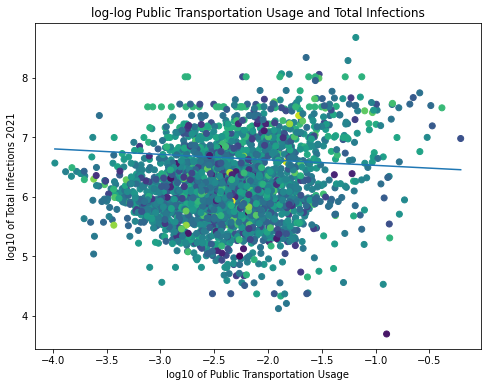

In [119]:
x1i = np.min(logtrans)
x1f = np.max(logtrans)
x2i = np.min(logdensity)
x2f = np.max(logdensity)
x3i = np.min(interaction)
x3f = np.max(interaction)
yi = interceptvalue + slopetrans*x1i+slopedensity*x2i+slopeinteraction*x3i
yf = interceptvalue + slopetrans*x1f+slopedensity*x2f+slopeinteraction*x3f
xarray = ([x1i, x1f])
yarray = ([yi, yf])
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(logtrans, loginf, c = logdensity)
plt.plot(xarray, yarray)
plt.xlabel('log10 of Public Transportation Usage')
plt.ylabel('log10 of Total Infections 2021')
ax.set(title='log-log Public Transportation Usage and Total Infections')

Now I'm going to create a nonlinear model, hopefully to capture the shape of the data drawn above. I don't predict this is very likely; the data seem to have no clear relationship. Even if there is an effect from population density and/or the interactions thereof, it's not likely it's substantial based on linear model slope information: the intercept is substantially larger than any other slope value, meaning it likely simply represents the average total infections.

In [120]:
#lets do some minimization!
#code takes a few minutes depending on steps size ^ 3

from scipy.optimize import minimize
import math

errorvals = []
avals = []
bvals = []
cvals = []
bipolarrange = 1000
steps = 10
incrementsize = math.floor((bipolarrange*2)/steps)

if steps >= 20: 
    print('number of combinations is:', steps**3, 'which may take a minute')

def error(params):
        a, b, c = params
        #array of guesses
        y = (a*logtrans)/logdensity+b*interaction+c
        #print(err)
        return np.sum((y-loginf)**2)

for a in range(-bipolarrange, bipolarrange, incrementsize):
    for b in range (-bipolarrange, bipolarrange, incrementsize):
        for c in range (-bipolarrange, bipolarrange, incrementsize):
            ic = [a, b, c]
            sol = minimize(error, ic)
            avals.append(sol.x[0])
            bvals.append(sol.x[1])
            cvals.append(sol.x[2])
            errorvals.append(error(ic))

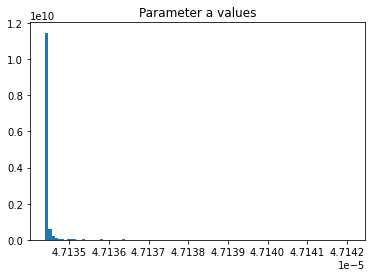

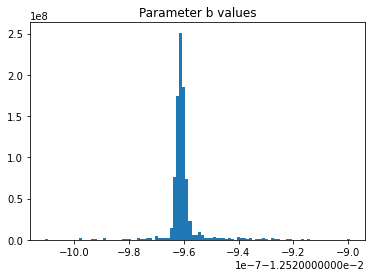

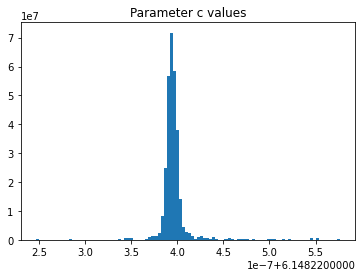

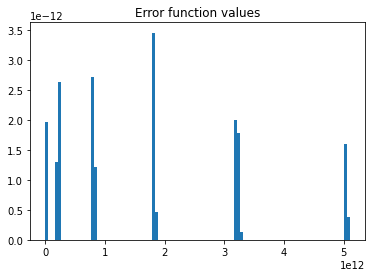

In [121]:
#now lets plot these values to see if we can learn anything

bins = 100

plt.hist(avals, density = True, bins = bins)
plt.title('Parameter a values')
plt.show()
plt.hist(bvals, density = True, bins = bins)
plt.title('Parameter b values')
plt.show()
plt.hist(cvals, density = True, bins = bins)
plt.title('Parameter c values')
plt.show()
plt.hist(errorvals, density = True, bins = bins)
plt.title('Error function values')
plt.show()

[Text(0.5, 1.0, 'log-log Public Transportation Usage and Total Infections')]

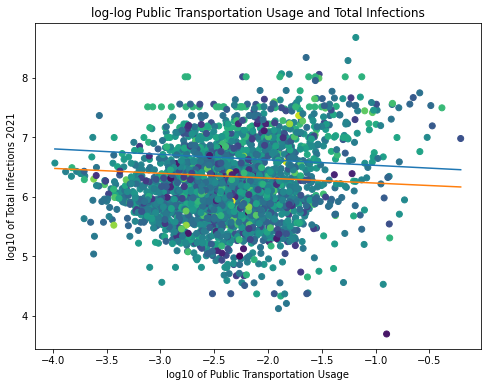

In [124]:
gooderrorvals = []
goodavals = []
goodbvals = []
goodcvals = []

for k in range(len(cvals)):
    if errorvals[k] <= 0.5*(10**12):
        gooderrorvals.append(errorvals[k])
        goodavals.append(avals[k])
        goodbvals.append(bvals[k])
        goodcvals.append(cvals[k])

gooda = np.average(goodavals)
goodb = np.average(goodbvals)
goodc = np.average(goodcvals)

def nonlinmodel(params):
    x1, x2, x3 = params
    y = gooda*x1/x2+goodb*x3+goodc
    return(y)

nonlinxarray = [x1i, x1f]
nonlinyarray = [nonlinmodel([x1i, x2i, x3i]), nonlinmodel([x1f, x2f, x3f])]

fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(logtrans, loginf, c = logdensity)
plt.plot(xarray, yarray)
plt.plot(nonlinxarray, nonlinyarray)
plt.plot()
plt.xlabel('log10 of Public Transportation Usage')
plt.ylabel('log10 of Total Infections 2021')
ax.set(title='log-log Public Transportation Usage and Total Infections')

These fits aren't very good: there aren't clear relationships between these data. This can be quantified via a simple comparison of SSE below: